In [1]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using LinearAlgebra
using CSV
using StatsBase
include("utils.jl")
include("financial_bvar_temp.jl")
using .FinancialBVAR

In [136]:
df = DataFrame(XLSX.readtable("usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), month, last)

872×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬─────────┬────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E       │ CAPE  ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼─────────┼────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │    2.44 │ 12.52 ⋯
│ 1952-01-01 │  0.02463 │   104.771 │       23.75 │  1.41667 │ 2.42667 │ 12.36 ⋯
│ 1952-02-01 │  0.02617 │   103.585 │       23.81 │     1.42 │ 2.41333 │ 12.36 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │     2.4 │ 12.24 ⋯
│ 1952-04-01 │  0.02422 │   105.806 │       23.73 │     1.44 │    2.38 │ 12.20 ⋯
│ 1952-05-01 │  0.02384 │   106.373 │       24.38 │     1.45 │    2.36 │ 12.44 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │    2.34 │ 12.66 ⋯
│ 1952-07-01 │  0.02466 │   106.034 │       25.18 │     1.45 │ 2.34667 │ 12.67 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [137]:
colnames(data_source)

11-element Vector{Symbol}:
 :Yeld_10Y
 :Price_10Y
 :Stock_Price
 :Dividend
 :E
 :CAPE
 :T_Bill
 :CPI
 :Dividend_Yeld
 :Total_Stock_2
 :Total_Stock

In [138]:
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns = merge(returns, log1p.(data_source[:T_Bill])./4)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
term = data_source[:Yeld_10Y] ./4 .- data_source[:T_Bill] ./4
dy = data_source[:Dividend_Yeld] #log.(data_source[:Dividend_Yeld])
data = merge(real_returns, dy, term, cpi)

871×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-01-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1952-01-01 │     -0.00573091 │     0.0140246 │   0.0114703 │     0.0596493 │ ⋯
│ 1952-02-01 │      0.00746826 │    -0.0113865 │  0.00382066 │     0.0596388 │ ⋯
│ 1952-03-01 │     -0.00171751 │    0.00809556 │ 0.000148659 │     0.0602359 │ ⋯
│ 1952-04-01 │      0.00462495 │    0.00932199 │  0.00389451 │     0.0606827 │ ⋯
│ 1952-05-01 │       0.0280548 │    0.00156172 │ 0.000359799 │      0.059475 │ ⋯
│ 1952-06-01 │       0.0254613 │   -0.00825169 │ -0.00330455 │      0.057815 │ ⋯
│ 1952-07-01 │      0.00874765 │   -0.00245285 │  0.00448454 │     0.0575854 │ ⋯
│ 1952-08-01 │      -0.0110704 │   -0.00545266 │  0.00453364 │     0.0585149 │ ⋯
│     ⋮      │        ⋮        │ 

In [139]:
CSV.write("usa_data_transformed.csv", data)

"usa_data_transformed.csv"

In [193]:
start = Date(2003,01,01)
end_d = Date(2018, 12, 31)
s_data = to(from(data, start),end_d)

192×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2003-01-01 to 2018-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 2003-01-01 │      -0.0738559 │    -0.0183447 │ -0.00476746 │     0.0193183 │ ⋯
│ 2003-02-01 │      0.00699136 │     0.0208587 │ -0.00308165 │     0.0191583 │ ⋯
│ 2003-03-01 │       0.0536074 │   -0.00458111 │  0.00498307 │     0.0182054 │ ⋯
│ 2003-04-01 │       0.0533206 │   -7.40732e-5 │   0.0044427 │     0.0172942 │ ⋯
│ 2003-05-01 │       0.0543118 │     0.0446185 │  0.00157147 │     0.0163664 │ ⋯
│ 2003-06-01 │      0.00485867 │    -0.0124574 │  0.00120135 │     0.0164326 │ ⋯
│ 2003-07-01 │     -0.00544783 │    -0.0789654 │ -0.00155926 │     0.0166241 │ ⋯
│ 2003-08-01 │       0.0278491 │    0.00365194 │ -0.00088121 │     0.0162736 │ ⋯
│     ⋮      │        ⋮        │ 

In [194]:
returns_summarystats(to(from(returns, start),end_d), 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.0704,0.4634,0.0289,0.1118,-0.8998,-1.9095,-0.0182,0.2626,9.6639,0.4095,0.0574
Price_10Y,0.0424,0.3656,0.0121,0.0605,-0.3007,0.0556,-0.0307,0.0381,2.0738,0.2864,0.011
T_Bill,0.0076,0.0491,0.0121,0.0184,0.0001,1.2601,0.0008,0.9935,0.3138,1.6041,0.0039


In [195]:
returns_summarystats(s_data, 1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0349,0.1134,0.0055,0.0253,-0.2148,-1.7132,-0.0072,0.2359,8.1105,0.158,0.0119
Price_10Y_CPI,0.0222,0.1018,0.0013,0.0134,-0.079,0.1117,-0.0105,0.0993,2.4759,0.0602,0.0006
T_Bill_CPI,0.0051,0.021,0.0013,0.0037,-0.0094,0.9806,-0.0022,0.7075,1.3671,0.2608,0.0005
Dividend_Yeld,0.0032,0.036,0.0199,0.0208,0.0155,2.5413,0.0179,0.9637,8.2684,6.1702,0.0194
Yeld_10Y_T_Bill,0.0026,0.0095,0.0048,0.0067,-0.0012,-0.3364,0.0031,0.9588,-0.6026,1.871,0.0051
CPI,0.004,0.0121,0.0017,0.0044,-0.0193,-0.9116,-0.0007,0.5105,3.8164,0.4292,0.0018


In [196]:
returns_summarystats(s_data, 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0698,0.4535,0.0221,0.1012,-0.8592,-1.7132,-0.0288,0.2359,8.1105,0.316,0.0474
Price_10Y_CPI,0.0444,0.4072,0.0053,0.0538,-0.3159,0.1117,-0.0421,0.0993,2.4759,0.1204,0.0023
T_Bill_CPI,0.0103,0.084,0.0054,0.0147,-0.0375,0.9806,-0.0088,0.7075,1.3671,0.5217,0.0019
Dividend_Yeld,0.0064,0.144,0.0794,0.083,0.0622,2.5413,0.0716,0.9637,8.2684,12.3404,0.0778
Yeld_10Y_T_Bill,0.0051,0.038,0.0192,0.0268,-0.0048,-0.3364,0.0123,0.9588,-0.6026,3.742,0.0204
CPI,0.0079,0.0486,0.0068,0.0176,-0.0774,-0.9116,-0.0027,0.5105,3.8164,0.8584,0.0073


In [197]:
#returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns1y = from(to(percentchange(collapse(data_source[:Total_Stock, :Price_10Y],year, last), :log),end_d),start)
returns_summarystats(returns1y,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1735,0.2867,0.0866,0.1991,-0.4393,-1.7318,0.0216,-0.1363,3.3138,0.499,0.1259
Price_10Y,0.0755,0.1857,0.0364,0.0817,-0.1063,0.0544,0.0025,-0.2611,-0.015,0.4826,0.0272


In [198]:
returns1y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],4) ./1
returns3y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],12) ./3
returns5y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],20) ./5
returns10y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],40) ./10
cum_returns = merge(TimeSeries.rename!(returns1y, [:RealStock1y, :RealBonds1y, :RealTBill1y]), 
                    TimeSeries.rename!(returns3y, [:RealStock3y, :RealBonds3y, :RealTBill3y]), 
                    TimeSeries.rename!(returns5y, [:RealStock5y, :RealBonds5y, :RealTBill5y]),
                    TimeSeries.rename!(returns10y, [:RealStock10y, :RealBonds10y, :RealTBill10y]))
returns_summarystats(expm1.(cum_returns),1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
RealStock1y,0.0826,0.2319,0.0236,0.0749,-0.2786,-1.0925,-0.0063,0.8514,2.4577,0.2851,0.0363
RealBonds1y,0.048,0.1965,0.0078,0.0333,-0.0895,0.6279,-0.0204,0.7813,1.1299,0.1629,0.0079
RealTBill1y,0.0177,0.06,0.0044,0.0082,-0.0243,1.2541,-0.007,0.9315,1.1488,0.2471,-0.0002
RealStock3y,0.0542,0.1501,0.0229,0.0538,-0.1594,-1.5925,0.0056,0.9482,2.9961,0.422,0.0386
RealBonds3y,0.0212,0.0638,0.0065,0.0209,-0.0431,-0.0646,-0.0105,0.8856,-0.68,0.3082,0.0089
RealTBill3y,0.0144,0.0419,0.0046,0.0098,-0.0116,1.3792,-0.0049,0.9853,0.7278,0.3169,-0.0018
RealStock5y,0.0421,0.0979,0.0221,0.0496,-0.1265,-1.5252,0.0119,0.9699,2.3538,0.5239,0.0281
RealBonds5y,0.0158,0.0508,0.0069,0.0175,-0.0247,0.2034,-0.005,0.9185,-0.4841,0.4377,0.0066
RealTBill5y,0.0139,0.0377,0.0048,0.0097,-0.0097,1.2204,-0.0046,0.991,0.1424,0.3465,-0.0017
RealStock10y,0.0267,0.0601,0.0207,0.0388,-0.0482,-0.8249,0.0017,0.9797,-0.5194,0.7748,0.031


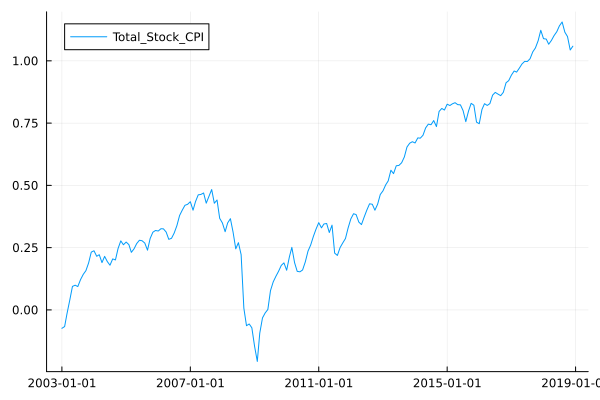

In [199]:
plot(cumsum(s_data[:Total_Stock_CPI]))

In [200]:
vmodel = VARModel(s_data)
model_summary(vmodel)

,const,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI,std
Total_Stock_CPI,0.0047,0.2366,-0.0069,-0.9009,0.3605,-0.8256,-1.2192,0.0338
Price_10Y_CPI,-0.0089,-0.1841,0.0223,1.4359,-0.0596,2.3619,-0.4515,0.0196
T_Bill_CPI,0.0005,-0.0268,-0.0129,0.9197,-0.0423,0.0003,0.4055,0.0033
Dividend_Yeld,0.0015,-0.0086,0.0005,-0.0136,0.9352,-0.0258,-0.0292,0.0008
Yeld_10Y_T_Bill,-0.0003,0.0019,0.0033,-0.0217,0.0233,0.9482,0.0172,0.0006
CPI,0.0001,0.0294,0.0088,0.0669,0.0196,-0.0091,0.5834,0.0033


,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI
Total_Stock_CPI,1.0,0.12,-0.01,-0.96,-0.11,0.01
Price_10Y_CPI,0.12,1.0,0.1,-0.12,-0.82,-0.12
T_Bill_CPI,-0.01,0.1,1.0,0.13,0.04,-0.99
Dividend_Yeld,-0.96,-0.12,0.13,1.0,0.14,-0.13
Yeld_10Y_T_Bill,-0.11,-0.82,0.04,0.14,1.0,-0.08
CPI,0.01,-0.12,-0.99,-0.13,-0.08,1.0


In [201]:
bmodel = NormalWishartBVAR(s_data)
sample_posterior!(bmodel,10000, 2000)
posterior_summary(bmodel)

"Total_Stock_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0400   -0.0104    0.0047    0.0196    0.0487
  Total_Stock_CPI    0.0892    0.1869    0.2372    0.2877    0.3882
    Price_10Y_CPI   -0.2426   -0.0888   -0.0069    0.0719    0.2284
       T_Bill_CPI   -3.0334   -1.6155   -0.8749   -0.1550    1.2771
    Dividend_Yeld   -1.3749   -0.2279    0.3665    0.9601    2.0782
  Yeld_10Y_T_Bill   -3.8048   -1.8293   -0.8414    0.2135    2.2074
              CPI   -3.7524   -2.0639   -1.2026   -0.3593    1.3229


"Price_10Y_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0343   -0.0179   -0.0089   -0.0000    0.0169
  Total_Stock_CPI   -0.2688   -0.2134   -0.1842   -0.1542   -0.0962
    Price_10Y_CPI   -0.1154   -0.0250    0.0227    0.0674    0.1619
       T_Bill_CPI    0.2262    1.0090    1.4344    1.8511    2.6858
    Dividend_Yeld   -1.0743   -0.4126   -0.0570    0.2945    0.9391
  Yeld_10Y_T_Bill    0.6822    1.7671    2.3480    2.9427    4.1410
              CPI   -1.8934   -0.9448   -0.4523    0.0390    0.9891


"T_Bill_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0037   -0.0010    0.0005    0.0020    0.0047
  Total_Stock_CPI   -0.0412   -0.0316   -0.0267   -0.0219   -0.0128
    Price_10Y_CPI   -0.0353   -0.0207   -0.0128   -0.0051    0.0101
       T_Bill_CPI    0.7064    0.8470    0.9185    0.9891    1.1219
    Dividend_Yeld   -0.2127   -0.1012   -0.0438    0.0151    0.1246
  Yeld_10Y_T_Bill   -0.2942   -0.0981   -0.0018    0.0956    0.2904
              CPI    0.1586    0.3195    0.4044    0.4873    0.6443


"Dividend_Yeld coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const    0.0005    0.0012    0.0015    0.0019    0.0026
  Total_Stock_CPI   -0.0123   -0.0098   -0.0085   -0.0073   -0.0050
    Price_10Y_CPI   -0.0052   -0.0015    0.0005    0.0025    0.0062
       T_Bill_CPI   -0.0662   -0.0316   -0.0142    0.0036    0.0386
    Dividend_Yeld    0.8934    0.9204    0.9348    0.9495    0.9770
  Yeld_10Y_T_Bill   -0.0991   -0.0511   -0.0260   -0.0009    0.0461
              CPI   -0.0898   -0.0503   -0.0296   -0.0088    0.0321


"Yeld_10Y_T_Bill coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0011   -0.0005   -0.0003    0.0000    0.0006
  Total_Stock_CPI   -0.0009    0.0010    0.0019    0.0029    0.0048
    Price_10Y_CPI   -0.0012    0.0018    0.0033    0.0049    0.0078
       T_Bill_CPI   -0.0610   -0.0356   -0.0219   -0.0081    0.0183
    Dividend_Yeld   -0.0106    0.0119    0.0235    0.0348    0.0574
  Yeld_10Y_T_Bill    0.8917    0.9291    0.9479    0.9673    1.0031
              CPI   -0.0294    0.0009    0.0170    0.0330    0.0654


"CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0042   -0.0014    0.0000    0.0015    0.0042
  Total_Stock_CPI    0.0152    0.0245    0.0293    0.0341    0.0437
    Price_10Y_CPI   -0.0141    0.0010    0.0087    0.0166    0.0312
       T_Bill_CPI   -0.1362   -0.0028    0.0681    0.1392    0.2785
    Dividend_Yeld   -0.1481   -0.0381    0.0213    0.0785    0.1892
  Yeld_10Y_T_Bill   -0.2969   -0.1052   -0.0064    0.0901    0.2815
              CPI    0.3457    0.5002    0.5843    0.6690    0.8316


"correlation matrix"

Quantiles
                       parameters      2.5%     25.0%     50.0%     75.0%      ⋯
                           Symbol   Float64   Float64   Float64   Float64   Fl ⋯

  Total_Stock_CPI_Total_Stock_CPI    0.0310    0.0331    0.0344    0.0357    0 ⋯
    Total_Stock_CPI_Price_10Y_CPI   -0.0263    0.0706    0.1213    0.1702    0 ⋯
       Total_Stock_CPI_T_Bill_CPI   -0.1552   -0.0608   -0.0120    0.0384    0 ⋯
    Total_Stock_CPI_Dividend_Yeld   -0.9713   -0.9653   -0.9617   -0.9576   -0 ⋯
  Total_Stock_CPI_Yeld_10Y_T_Bill   -0.2521   -0.1617   -0.1111   -0.0606    0 ⋯
              Total_Stock_CPI_CPI   -0.1323   -0.0382    0.0123    0.0617    0 ⋯
    Price_10Y_CPI_Total_Stock_CPI   -0.0263    0.0706    0.1213    0.1702    0 ⋯
      Price_10Y_CPI_Price_10Y_CPI    0.0180    0.0192    0.0199    0.0206    0 ⋯
         Price_10Y_CPI_T_Bill_CPI   -0.0384    0.0565    0.1055    0.1542    0 ⋯
      Price_10Y_CPI_Dividend_Yeld   -0.2602   -0.1692   -0.1195   -0.0686    0 ⋯
    Price_10Y_CPI

In [202]:
#83-2023
assets_names = colnames(s_data)
scenarios = simulate(vmodel,60)

for n in 1:6
    s_ann = annualise(scenarios[n,:,2:end],4)
    print_percentiles(s_ann,[0.05, 0.25, 0.5, 0.75, 0.95], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.1019,-0.1043,-0.1091,-0.113,-0.1138,-0.1135,-0.1166,-0.1141,-0.1119,-0.1161,-0.1145,-0.1168,-0.1126,-0.1139,-0.1141
0.25,-0.0235,-0.0277,-0.0309,-0.0335,-0.0339,-0.0346,-0.0352,-0.0357,-0.0353,-0.0377,-0.037,-0.0366,-0.035,-0.0359,-0.0358
0.5,0.0294,0.0264,0.0239,0.0222,0.0225,0.0211,0.02,0.0203,0.0198,0.02,0.0177,0.0187,0.0206,0.0181,0.0201
0.75,0.0847,0.0797,0.0782,0.0769,0.077,0.0765,0.0754,0.0752,0.0748,0.0757,0.0738,0.0738,0.0753,0.0746,0.0765
0.95,0.164,0.1561,0.1568,0.1597,0.1551,0.1563,0.1554,0.1531,0.1553,0.1559,0.1545,0.1508,0.1557,0.155,0.1542


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0892,-0.0886,-0.0852,-0.0822,-0.0827,-0.081,-0.08,-0.0788,-0.0751,-0.0771,-0.0752,-0.0747,-0.0782,-0.0756,-0.0747
0.25,-0.0492,-0.0449,-0.0408,-0.038,-0.0361,-0.0339,-0.0325,-0.0306,-0.0305,-0.03,-0.0292,-0.0287,-0.0292,-0.0287,-0.0298
0.5,-0.0208,-0.0133,-0.0088,-0.006,-0.0028,-0.0016,0.001,0.0014,0.0014,0.0025,0.0033,0.0038,0.0037,0.004,0.0035
0.75,0.0078,0.0172,0.0227,0.0254,0.0289,0.0309,0.0321,0.0338,0.034,0.0343,0.0362,0.0365,0.0348,0.0364,0.0356
0.95,0.0476,0.063,0.0682,0.0716,0.0743,0.0762,0.0794,0.0811,0.0792,0.0801,0.081,0.0833,0.0815,0.0827,0.0814


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0032,-0.0031,-0.004,-0.0049,-0.0057,-0.0064,-0.0073,-0.0082,-0.0089,-0.0092,-0.0104,-0.0107,-0.0122,-0.0118,-0.0122
0.25,0.0068,0.0074,0.0073,0.0071,0.0068,0.0062,0.006,0.0057,0.0052,0.0047,0.0046,0.0039,0.0034,0.0033,0.003
0.5,0.0139,0.015,0.0154,0.0153,0.0152,0.0152,0.015,0.0152,0.0147,0.0151,0.0149,0.0145,0.0143,0.014,0.0137
0.75,0.0209,0.0225,0.0233,0.0236,0.024,0.024,0.0244,0.0246,0.0244,0.0247,0.0248,0.0251,0.025,0.0248,0.0247
0.95,0.0309,0.0332,0.0349,0.0351,0.0363,0.0368,0.0375,0.0381,0.0388,0.039,0.0398,0.0402,0.0407,0.0404,0.0402


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,0.0737,0.067,0.0642,0.0624,0.0615,0.061,0.0609,0.0605,0.0603,0.06,0.0598,0.0596,0.0601,0.0599,0.0596
0.25,0.0791,0.0762,0.0747,0.0738,0.0733,0.0729,0.0727,0.0728,0.0725,0.0724,0.072,0.0724,0.0722,0.0723,0.072
0.5,0.0827,0.0823,0.082,0.0819,0.0817,0.0814,0.0814,0.0812,0.0811,0.0807,0.081,0.0809,0.0806,0.0807,0.0806
0.75,0.0862,0.0887,0.0896,0.09,0.0901,0.0899,0.0898,0.0896,0.0896,0.0894,0.0896,0.0894,0.0892,0.0891,0.0891
0.95,0.0914,0.0977,0.1001,0.1015,0.1022,0.1021,0.1018,0.102,0.1018,0.1015,0.1018,0.102,0.1018,0.1015,0.1015


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0002,-0.0016,-0.0021,-0.0023,-0.0024,-0.0024,-0.0022,-0.0025,-0.0028,-0.0031,-0.0032,-0.0033,-0.0035,-0.0034,-0.0031
0.25,0.0028,0.0032,0.0038,0.0045,0.0049,0.0052,0.0055,0.0057,0.0059,0.0061,0.0062,0.0063,0.0065,0.0065,0.0067
0.5,0.005,0.0066,0.008,0.009,0.0099,0.0105,0.0111,0.0117,0.0121,0.0124,0.0127,0.0128,0.013,0.0132,0.0133
0.75,0.0071,0.0101,0.0121,0.0136,0.015,0.0159,0.0168,0.0174,0.0179,0.0184,0.0188,0.0192,0.0195,0.0198,0.02
0.95,0.0102,0.015,0.018,0.02,0.0218,0.0237,0.0248,0.0257,0.0264,0.0273,0.0277,0.028,0.0291,0.0291,0.0294


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.008,-0.0104,-0.0102,-0.0103,-0.0102,-0.0103,-0.0105,-0.011,-0.0104,-0.0106,-0.0108,-0.0109,-0.0113,-0.011,-0.011
0.25,0.002,0.001,0.0006,0.0008,0.0006,0.0006,0.0005,0.0003,0.0003,0.0003,0.0001,0.0001,0.0,0.0002,0.0004
0.5,0.0094,0.0086,0.0081,0.0082,0.0082,0.0083,0.0081,0.0078,0.008,0.008,0.0078,0.0077,0.0079,0.0078,0.0077
0.75,0.0164,0.0162,0.016,0.016,0.0159,0.016,0.0158,0.0155,0.016,0.0155,0.0155,0.0155,0.0158,0.0155,0.0157
0.95,0.0269,0.0269,0.0268,0.0268,0.0267,0.0269,0.0266,0.0269,0.0269,0.0263,0.0268,0.0267,0.027,0.0269,0.0268


In [203]:
scenarios_b = simulate(bmodel,60, 10)
for n in 1:6
    s_ann = annualise(scenarios_b[n,:,2:end],4)
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0246,-0.06,-0.0807,-0.0947,-0.1036,-0.1108,-0.1172,-0.1235,-0.1273,-0.1306,-0.1315,-0.1342,-0.1366,-0.139,-0.1397
0.25,0.013,0.0022,-0.0018,-0.0045,-0.0066,-0.0078,-0.0087,-0.0093,-0.0099,-0.0103,-0.0109,-0.0114,-0.0115,-0.0117,-0.0118
0.5,0.0299,0.0248,0.0234,0.0226,0.0222,0.0219,0.0219,0.0221,0.0222,0.0221,0.0221,0.0221,0.0223,0.0226,0.0227
0.75,0.0475,0.048,0.049,0.0495,0.0502,0.0507,0.0516,0.0523,0.0528,0.0532,0.0538,0.0546,0.0551,0.0559,0.0565
0.98,0.0915,0.1205,0.1332,0.1405,0.1474,0.1522,0.1561,0.1603,0.165,0.1678,0.1699,0.174,0.179,0.1837,0.1878


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0618,-0.089,-0.0989,-0.1036,-0.1057,-0.1056,-0.1071,-0.1083,-0.109,-0.1087,-0.1089,-0.1088,-0.1096,-0.1107,-0.1109
0.25,-0.032,-0.033,-0.0328,-0.0325,-0.0316,-0.031,-0.0306,-0.0302,-0.0299,-0.0298,-0.0297,-0.0297,-0.0298,-0.0299,-0.0302
0.5,-0.0198,-0.0114,-0.0073,-0.0048,-0.0027,-0.0012,0.0001,0.0009,0.0013,0.0019,0.0024,0.0025,0.0025,0.0024,0.0025
0.75,-0.0086,0.0084,0.0168,0.0222,0.0258,0.0282,0.0306,0.032,0.033,0.0335,0.0341,0.0349,0.0351,0.0357,0.0357
0.98,0.0142,0.0579,0.0803,0.0927,0.0999,0.1046,0.1083,0.1101,0.1116,0.1134,0.1146,0.1156,0.1163,0.1162,0.1176


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0015,-0.0136,-0.0217,-0.0274,-0.0322,-0.0364,-0.0403,-0.0438,-0.0473,-0.05,-0.0534,-0.0565,-0.0593,-0.0626,-0.0653
0.25,0.0091,0.0063,0.0041,0.0024,0.001,-0.0004,-0.0015,-0.0026,-0.0035,-0.0046,-0.0055,-0.0062,-0.0072,-0.0079,-0.0085
0.5,0.0139,0.0151,0.0154,0.0155,0.0155,0.0155,0.0154,0.0152,0.0152,0.0151,0.0149,0.0148,0.0147,0.0145,0.0143
0.75,0.0187,0.024,0.0268,0.0287,0.0303,0.0316,0.0327,0.0335,0.0344,0.0352,0.0359,0.0367,0.0372,0.0379,0.0385
0.98,0.0288,0.0437,0.0527,0.0587,0.0643,0.0688,0.0725,0.0765,0.0802,0.084,0.0874,0.0916,0.0953,0.0994,0.1036


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.0697,0.0607,0.0553,0.0507,0.0468,0.0431,0.0397,0.0364,0.0336,0.0309,0.0286,0.0261,0.0236,0.0211,0.0181
0.25,0.0785,0.0754,0.0736,0.0723,0.0712,0.0702,0.0696,0.069,0.0683,0.0679,0.0674,0.0671,0.0668,0.0665,0.0661
0.5,0.0827,0.0823,0.0819,0.0817,0.0815,0.0812,0.0809,0.0808,0.0806,0.0804,0.0803,0.0801,0.08,0.0799,0.0798
0.75,0.0868,0.0893,0.0905,0.0914,0.0921,0.0925,0.0927,0.0928,0.093,0.0932,0.0932,0.0933,0.0933,0.0934,0.0934
0.98,0.0955,0.1044,0.1103,0.115,0.119,0.1227,0.1256,0.1286,0.1306,0.1325,0.1342,0.1362,0.1379,0.1394,0.1409


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.008,-0.0153,-0.0195,-0.0229,-0.0258,-0.0285,-0.0311,-0.0338,-0.0363,-0.0393,-0.0421,-0.0455,-0.0481,-0.0513,-0.0551
0.25,0.0009,-0.0002,-0.0005,-0.0007,-0.0008,-0.0009,-0.0012,-0.0014,-0.0018,-0.0021,-0.0024,-0.0026,-0.0028,-0.0031,-0.0033
0.5,0.005,0.0068,0.008,0.009,0.0098,0.0103,0.0109,0.0114,0.0117,0.0121,0.0123,0.0125,0.0126,0.0126,0.0129
0.75,0.0092,0.0136,0.0163,0.0184,0.0201,0.0214,0.0227,0.0237,0.0246,0.0253,0.026,0.0266,0.027,0.0276,0.0282
0.98,0.0179,0.028,0.0337,0.0383,0.042,0.0453,0.0486,0.051,0.0538,0.0562,0.0584,0.0608,0.0635,0.0656,0.0674


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0016,-0.0068,-0.0089,-0.0104,-0.0118,-0.0127,-0.0137,-0.0144,-0.0151,-0.0163,-0.0168,-0.0174,-0.0181,-0.0188,-0.0192
0.25,0.0059,0.004,0.0034,0.0031,0.0028,0.0026,0.0024,0.0022,0.0021,0.002,0.0018,0.0017,0.0016,0.0015,0.0015
0.5,0.0093,0.0084,0.0082,0.0082,0.0081,0.008,0.008,0.0079,0.0079,0.0078,0.0078,0.0078,0.0078,0.0078,0.0078
0.75,0.0128,0.0129,0.0131,0.0133,0.0135,0.0136,0.0137,0.0139,0.0139,0.014,0.0141,0.0142,0.0143,0.0144,0.0146
0.98,0.0202,0.0238,0.0259,0.0273,0.0287,0.03,0.031,0.0321,0.0328,0.034,0.035,0.0362,0.0368,0.0379,0.0391


In [204]:
# annualised compounded returns for 1, 5, 10, 15 years
for n in 1:3
    cum_ret = cumsum(scenarios[n,:,2:end]; dims=2)
    print_percentiles(expm1.(cum_ret[:,[4,20,40,60]] ./ [1 5 10 15]),[.02, .1, .25, .5, .75, .9, .98], string(assets_names[n]))    
end

,1,2,3,4
0.02,-0.126,-0.0451,-0.0238,-0.0142
0.1,-0.0703,-0.0192,-0.0063,-0.001
0.25,-0.0233,0.002,0.0073,0.0098
0.5,0.0298,0.0249,0.0227,0.0214
0.75,0.0884,0.0491,0.0383,0.0338
0.9,0.1446,0.0715,0.0532,0.0455
0.98,0.2154,0.1007,0.0714,0.0596


,1,2,3,4
0.02,-0.1019,-0.0399,-0.0228,-0.0155
0.1,-0.0722,-0.0289,-0.0162,-0.0105
0.25,-0.048,-0.0204,-0.0107,-0.0066
0.5,-0.0206,-0.0107,-0.0049,-0.0023
0.75,0.0079,-0.0004,0.0011,0.0023
0.9,0.0335,0.0089,0.0062,0.0062
0.98,0.0673,0.0206,0.0134,0.0117


,1,2,3,4
0.02,-0.0074,0.0028,0.0027,0.0007
0.1,0.0006,0.0074,0.0073,0.006
0.25,0.0068,0.011,0.011,0.0102
0.5,0.014,0.0151,0.0151,0.0149
0.75,0.0212,0.0192,0.0193,0.0195
0.9,0.0276,0.0228,0.0231,0.0238
0.98,0.0356,0.0275,0.0279,0.0294


In [205]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios[n,:,2:end], 20))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end


,1,2,3
0.02,-0.2059,-0.2316,-0.2351
0.25,0.01,-0.0203,-0.0245
0.5,0.131,0.1052,0.1008
0.75,0.2708,0.2457,0.2424
0.98,0.6159,0.5954,0.603


,1,2,3
0.02,-0.1843,-0.1707,-0.1591
0.25,-0.0977,-0.057,-0.0448
0.5,-0.0523,0.0032,0.0182
0.75,-0.0018,0.068,0.0817
0.98,0.1071,0.2069,0.2307


,1,2,3
0.02,0.0141,-0.0241,-0.0467
0.25,0.0564,0.0441,0.032
0.5,0.0778,0.0785,0.0738
0.75,0.0997,0.1131,0.1177
0.98,0.1451,0.1894,0.2138


In [206]:
scenarios[1,:,14:26]

10000×13 Matrix{Float64}:
 -0.00052044  -0.059691    -0.0158259    …  -0.0377572   -0.0308882
  0.0574905    0.0105575   -0.0372699        0.0456081    0.0175504
 -0.0482636    0.00835046  -0.0334216       -0.0316122   -0.0302585
 -0.0194962    0.00979708  -0.020712        -0.00701489  -0.0597877
 -0.0113603   -0.0660065   -0.0359369        0.0593091    0.079878
  0.0546878    0.0191711   -0.035829     …  -0.0113269   -0.0845484
 -0.0104355    0.0334313    0.0214711       -0.0331003   -0.0384033
  0.056853     0.00600923   0.00503757      -0.0252063   -0.0239704
 -0.030805    -0.0360804   -0.0116822        0.0180556   -0.000935246
 -0.0274968    0.00622983   0.00055743       0.0216023   -0.00574001
  ⋮                                      ⋱               
  0.0190073   -0.078659    -0.0354541       -0.00684638   0.0169526
  0.0589033    0.0486856   -0.000615259     -0.0189667   -0.0129368
  0.0110929    0.0612946   -0.00322539       0.0399147    0.0214307
  0.0374524    0.0619974    0.

In [207]:
quantile(sum(scenarios[1,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.22614982710367007
 -0.027617708669856904
  0.0693322793935336
  0.16760269410603545
  0.3738700614827356

In [208]:
quantile(sum(scenarios[2,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.17139250638649037
 -0.06353407262792132
 -0.010800283219592017
  0.04061782264195496
  0.14707223242358702

In [209]:
s_data

192×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2003-01-01 to 2018-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 2003-01-01 │      -0.0738559 │    -0.0183447 │ -0.00476746 │     0.0193183 │ ⋯
│ 2003-02-01 │      0.00699136 │     0.0208587 │ -0.00308165 │     0.0191583 │ ⋯
│ 2003-03-01 │       0.0536074 │   -0.00458111 │  0.00498307 │     0.0182054 │ ⋯
│ 2003-04-01 │       0.0533206 │   -7.40732e-5 │   0.0044427 │     0.0172942 │ ⋯
│ 2003-05-01 │       0.0543118 │     0.0446185 │  0.00157147 │     0.0163664 │ ⋯
│ 2003-06-01 │      0.00485867 │    -0.0124574 │  0.00120135 │     0.0164326 │ ⋯
│ 2003-07-01 │     -0.00544783 │    -0.0789654 │ -0.00155926 │     0.0166241 │ ⋯
│ 2003-08-01 │       0.0278491 │    0.00365194 │ -0.00088121 │     0.0162736 │ ⋯
│     ⋮      │        ⋮        │ 

In [210]:
 cov_m = cov(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI])) 
 mu = mean(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI]), dims=1) 

1×3 Matrix{Float64}:
 0.00551515  0.00133661  0.00133774

In [211]:
using Distributions
scenarios_n = zeros(3,100_000,60)

for t in 1:60
    scenarios_n[:,:,t] = rand(MvNormal(vec(mu), cov_m), 100_000)
end



In [212]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios_n[n,:,2:end], 20))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2
0.02,-0.1898,-0.1895
0.25,0.0058,0.0055
0.5,0.117,0.1172
0.75,0.2409,0.2408
0.98,0.5374,0.5335


,1,2
0.02,-0.1641,-0.1623
0.25,-0.0405,-0.0397
0.5,0.0268,0.0273
0.75,0.097,0.0984
0.98,0.2574,0.2575


,1,2
0.02,-0.0204,-0.02
0.25,0.0113,0.0114
0.5,0.027,0.0271
0.75,0.0431,0.0432
0.98,0.0765,0.0766


In [213]:
returns_summarystats(data_source[:Yeld_10Y],1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Yeld_10Y,0.0292,0.1584,0.055,0.0734,0.0055,0.9051,0.0334,0.9938,0.5752,1.8863,0.0474


In [214]:
yelds10y = dropdims(sum(scenarios[[3,5,6],:,:], dims=1), dims=1)
print_percentiles(annualise(yelds10y,4), [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.0232,0.0198,0.0189,0.0186,0.0187,0.0185,0.0184,0.0188,0.0186,0.0184,0.0181,0.0178,0.0178,0.017,0.0167
0.25,0.0261,0.0265,0.0272,0.0279,0.0285,0.0289,0.0293,0.0295,0.0294,0.0295,0.0295,0.0294,0.0294,0.0293,0.0292
0.5,0.0275,0.0297,0.0313,0.0324,0.0333,0.034,0.0343,0.0347,0.0348,0.035,0.035,0.0351,0.0351,0.0351,0.0352
0.75,0.029,0.033,0.0353,0.0368,0.0381,0.0389,0.0394,0.0399,0.0403,0.0404,0.0407,0.0408,0.0409,0.0409,0.041
0.98,0.0319,0.0396,0.0436,0.0461,0.0475,0.049,0.0503,0.0504,0.0508,0.0513,0.0519,0.0523,0.0529,0.0531,0.0533


In [215]:
include("generate_bond_temp.jl")

using .Bonds

bond_returns = Bonds.scenarios_bond_returns(yelds10y, 10, 4)
bond_returns_ann = annualise(bond_returns,4)
print_percentiles(bond_returns_ann, [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0202,-0.02,-0.0191,-0.019,-0.0191,-0.0188,-0.0181,-0.0179,-0.0167,-0.0174,-0.0168,-0.0163,-0.0171,-0.0168,-0.0162
0.25,-0.0059,-0.0046,-0.0032,-0.0022,-0.0016,-0.0011,-0.0004,-0.0001,0.0002,0.0003,0.0004,0.0006,0.0004,0.0007,0.0004
0.5,0.0012,0.0034,0.0048,0.0059,0.0068,0.0073,0.0081,0.0083,0.0083,0.0086,0.0088,0.0091,0.0088,0.0089,0.0088
0.75,0.0085,0.0113,0.0129,0.014,0.015,0.0157,0.0164,0.0167,0.0165,0.0169,0.0173,0.0173,0.017,0.0177,0.0173
0.98,0.0229,0.0278,0.0294,0.0308,0.0316,0.0323,0.0331,0.0341,0.0335,0.0339,0.0342,0.0345,0.0343,0.035,0.0346


In [216]:
#cpi_ann = annualise(scenarios[6,:,2:end],4)
cpi = scenarios[6,:,2:end]
real_bond_returns = bond_returns .- cpi
print_percentiles(expm1.(annualise(real_bond_returns, 4)), [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0414,-0.0417,-0.0408,-0.0397,-0.0402,-0.0395,-0.0396,-0.0388,-0.0371,-0.0379,-0.0376,-0.0375,-0.0391,-0.0377,-0.0365
0.25,-0.0194,-0.0176,-0.016,-0.015,-0.0145,-0.0137,-0.0129,-0.0124,-0.0128,-0.0123,-0.0117,-0.0116,-0.0121,-0.0118,-0.012
0.5,-0.0081,-0.0052,-0.0033,-0.0024,-0.0014,-0.001,-0.0002,0.0002,0.0004,0.0009,0.0009,0.0012,0.001,0.0012,0.0009
0.75,0.0032,0.0075,0.0094,0.0102,0.0115,0.0121,0.0129,0.0135,0.0135,0.0136,0.014,0.0141,0.0139,0.0144,0.0139
0.98,0.0264,0.0339,0.0361,0.0372,0.0384,0.0382,0.0399,0.0408,0.0398,0.0405,0.0408,0.042,0.0413,0.0415,0.0412


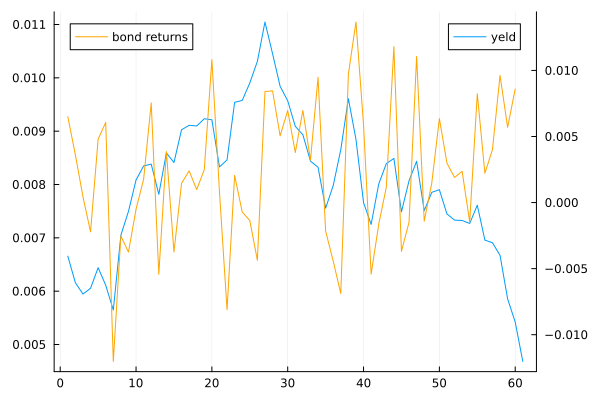

In [217]:
scenario = 13
plot(yelds10y[scenario,:], label="yeld")
plot!(twinx(), bond_returns[scenario,:], label="bond returns", color=:orange)